### We examine how the FB responds when we impose a force offset on one of the actuators
We use the same data as in a01_OL_stroke.ipynb. This test was done on Thursday night (3/4/20)

In [1]:
from openpyxl import load_workbook

from astropy.time import Time
from datetime import timedelta, datetime
from lsst_efd_client import EfdClient

import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pandas as pd
plt.jet()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
start = Time('2020-03-05T22:27:00') #this is UTC
end = Time('2020-03-05T22:38:00') 

In [4]:
mat = scipy.io.loadmat('mat/0305/CellTelemetry_2020-03-05_203926_002.mat')
print(mat['data'].dtype.names)
mdata = mat['data']  # variable in mat file
mdtype = mdata.dtype  # dtypes of structures are "unsized objects"
ndata = {n: mdata[n][0, 0] for n in mdtype.names}
t = [datetime.strptime(ts[0][0], '%d-%b-%Y %H:%M:%S.%f') for ts in ndata['timestamp']]
t = np.array([ti+ timedelta(hours=4, minutes=3, seconds=-5) for ti in t]) #convert to utc, 4 hours ahead of Rochester
columns = [n for n, v in ndata.items()]
nonHP = [i for i in range(78) if i+1 not in ndata['hp'][0,:]]
nonHPa = [i for i in range(72) if i+1 not in ndata['hp'][0,:]] #a for axial actuator only

def insertHPColumns(a):
    [n1, n2] = a.shape
    b = np.zeros((n1, n2+6))
    ii = 0
    for i in range(n2+6):
        if i in nonHP:
            b[:,i] = a[:,ii]
            ii += 1
        else:
            b[:,i] = 0
    return b

ndata['f_hp'] = insertHPColumns(ndata['f_hp'])
ndata['f_error'] = insertHPColumns(ndata['f_error'])

('time_delta', 'comm_cntr', 'ilc_status', 'encoder', 'force', 'disp_sensors', 'temp_sensors', 'inclinometer', 'step_cmd', 'inc_cal', 'elevation_ts_i', 'elevation_ts_u', 'elevation_ang', 'el_status', 'disp_proc', 'disp_status', 'temp_proc', 'temp_status', 'hp', 'f_e', 'f_0', 'f_a', 'f_f', 'T_u', 'T_x', 'T_y', 'T_r', 'f_hp', 'f_cmd', 'f_error', 'f_delta', 'f_cmd_wrd', 'mtr_voltage', 'comm_voltage', 'mtr_current', 'comm_current', 'dig_input', 'dig_output', 'mtr_voltage_proc', 'comm_voltage_proc', 'mtr_current_proc', 'comm_current_proc', 'time', 'timestamp')


In [5]:
# cut out only the time period we are interested in
idx = (t>start) & (t<end)
data = {}
for n, v in ndata.items():
    if len(v.shape)>1:
        data[n] = v[idx,:]
    else:
        data[n] = v[idx]
t = t[idx]

In [6]:
#get actuator coordinates, in the right coordinate system
aa = np.loadtxt('../github/data/M2_1um_72_force.txt')
# to have +x going to right, and +y going up, we need to transpose and reverse x and y
xact = -aa[:,2]
yact = -aa[:,1]
#actLabels = [i+10 for i in range(72)]

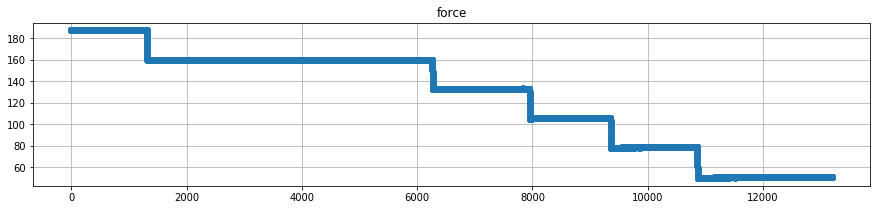

In [7]:
fig, ax = plt.subplots(figsize=(15,3))
plt.plot(data['force'][:,0],'-o')
plt.title('force')
plt.grid() 

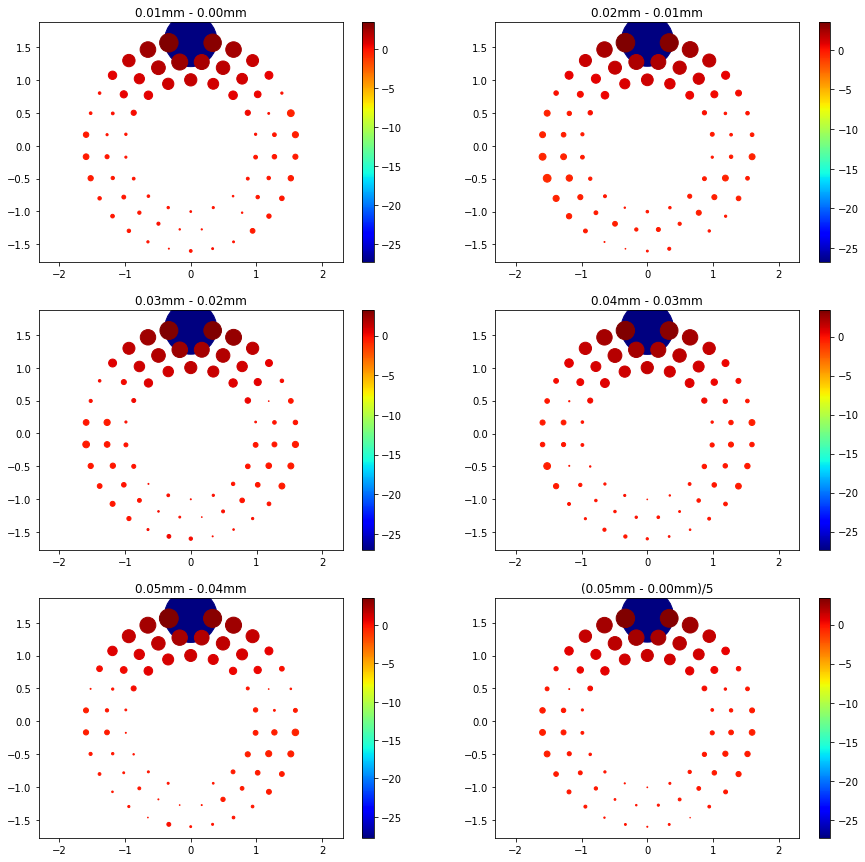

In [8]:
fig, ax = plt.subplots(3,2, figsize=(15,15))
idx = [0, 2000, 7000, 8500, 10000, 12000]
for i in range(6):
    irow = np.int8(i/2)
    icol = np.mod(i,2)
    if i<5:
        aa = data['force'][idx[i+1],:72]- data['force'][idx[i],:72] 
        bb = '%.2fmm - %.2fmm'%(0.01*(i+1), 0.01*i)
    else:
        aa = (data['force'][idx[-1],:72]- data['force'][idx[0],:72] )/5
        bb ='(0.05mm - 0.00mm)/5'
    img = ax[irow][icol].scatter(xact, yact, c=aa, s=abs(aa)*100)
    fig.colorbar(img, ax=ax[irow][icol])
    ax[irow][icol].axis('equal')
    ax[irow][icol].set_title(bb)


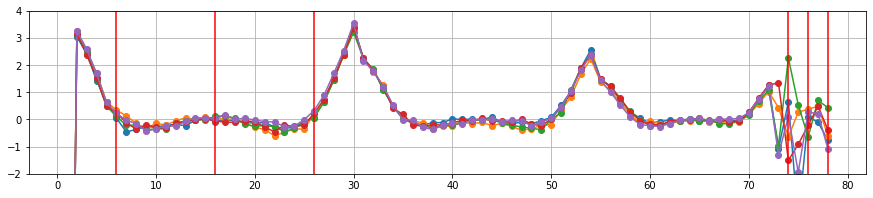

In [9]:
fig, ax = plt.subplots(figsize=(15,3))
x0 = np.linspace(1,78,78)
for i in range(5):
    aa = data['force'][idx[i+1],:]- data['force'][idx[i],:] 
    plt.plot(x0,aa,'-o')
plt.grid()
yy=[-2, 4]
plt.ylim(yy)
for i in data['hp'][0]:
    plt.plot([i,i],yy,'-r')
#ax.set_xticklabels(actLabels)

### This is our understanding from this test:
* stroke = position
* stroke and position are proportional to steps and encoder, 
* stroke and position are inversely proportional to forces (M2 facing down)
* M2 FB system seems to be working, but f_hp is useless, so are f_error and f_delta.
* Not sure what is going on with the tangent links. Perhaps what we see here (1 or 2N only) is in the noise?